# Removing blank spaces in csv with Pandas
CSV is a very common format for sharing the data. It's human readable (more-or-less), it's commonly undestandable and almost every programming language can read it. Unfortunately sometime the structure of the .csv file doesn't meet the rfc4180 (https://tools.ietf.org/html/rfc4180). This notebook provides options how to handle blank spaces, which are wrongly part of the csv. 

## Why do we care about removing blank space? 
There are two main reasons: 
* merging on values with and without blank spaces would fail " ABC" != "ABC"
* "", " " and NaN values behaves differenly
* blank spaces takes some place
* blank spaces might be breaking text design

In [1]:
import pandas as pd
import numpy as np
import io

In our sample data we have:
* **Id** which identifies each row
* **Street** which has initial and trailing white space
* **City** which has leading blank space
* **Salary** which is numeric
* **Date** which has date format

In [2]:
data = """Id,Street,City,Salary,Date
1, 5th Ave. , Indiana, 100, 2020-07-01
2, Downing Street , San Francisco, 200, 2020-07-02
3,  , New York, 300, 2020-07-03
4,   1600 Amphitheatre, New York, 400, 2020-07-04
"""

We will also prepare a function which will measure lengths of all items in each column and checks their type

In [3]:
expected = {"Id": 10,
           "Street": 39,
           "City": 36,
           "Salary": 1000,
           "Date": 4}

In [4]:
def df_statistics(df, expected=None):
    """Calculates the length of all items in the column and determine column types
       length of string
       sum of numbers"""
    
    res = {}
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]): 
            # calculate the length of each row and sum it
            # careful, you cannot .apply(len) to columns which contain NAN, because NAN are float. - see https://stackoverflow.com/questions/51460881/pandas-typeerror-object-of-type-float-has-no-len
            l = df[col].str.len().sum()
        else:
            try:# if it doesn't work, it's probably numeric value, so let's only sum
                l = df[col].sum()
            except:
                l = df[col].count()
        
        # assigne lenght to the "column_name_lenght" column
        res[str(col) + "_lenght"] = l
        
        # if a dict with expected values was provided, let's use it to compare with real values
        if expected:
            res[str(col) + "_diff"] = l-expected[col]
            
        # review the type of the colunmn   
        res[str(col) + "_type"] = df[col].dtype
    return res

## Benchmark unparametrized read_csv

In [5]:
df = pd.read_csv(io.StringIO(data), parse_dates=["Date"])

In [6]:
df

,Id,Street,City,Salary,Date
0,1,5th Ave.,Indiana,100,2020-07-01
1,2,Downing Street,San Francisco,200,2020-07-02
2,3,,New York,300,2020-07-03
3,4,1600 Amphitheatre,New York,400,2020-07-04


In [7]:
df.loc[0,"Id"], df.loc[0,"Street"], df.loc[0,"City"], df.loc[0,"Salary"], df.loc[0,"Date"]

(1, ' 5th Ave. ', ' Indiana', 100, Timestamp('2020-07-01 00:00:00'))

In [8]:
stats_df = pd.DataFrame(df_statistics(df, expected), index=["Benchmark"])
stats_df

,Id_lenght,Id_diff,Id_type,Street_lenght,Street_diff,Street_type,City_lenght,City_diff,City_type,Salary_lenght,Salary_diff,Salary_type,Date_lenght,Date_diff,Date_type
Benchmark,10,0,int64,48,9,object,40,4,object,1000,0,int64,4,0,datetime64[ns]


I'm not mentioning it here, but if you don't specify the column name in `parse_dates` parameter, it doesn't recognize the date, but it wouldn't even without the blank spaces.

## Using skipinitialspace
skipinitialspace option is there exactly to clear the leading white spaces. It won't touch the blank spaces at the ends or inside quotes.

In [9]:
df = pd.read_csv(io.StringIO(data), parse_dates=["Date"], skipinitialspace=True, )

In [10]:
df

,Id,Street,City,Salary,Date
0,1,5th Ave.,Indiana,100,2020-07-01
1,2,Downing Street,San Francisco,200,2020-07-02
2,3,NaN,New York,300,2020-07-03
3,4,1600 Amphitheatre,New York,400,2020-07-04


In [11]:
df.loc[0,"Id"], df.loc[0,"Street"], df.loc[0,"City"], df.loc[0,"Salary"], df.loc[0,"Date"]

(1, '5th Ave. ', 'Indiana', 100, Timestamp('2020-07-01 00:00:00'))

In [12]:
stats_df = pd.concat([stats_df, pd.DataFrame(df_statistics(df, expected), index=["Skipinitialspace"])])

In [13]:
stats_df

,Id_lenght,Id_diff,Id_type,Street_lenght,Street_diff,Street_type,City_lenght,City_diff,City_type,Salary_lenght,Salary_diff,Salary_type,Date_lenght,Date_diff,Date_type
Benchmark,10,0,int64,48.0,9.0,object,40,4,object,1000,0,int64,4,0,datetime64[ns]
Skipinitialspace,10,0,int64,41.0,2.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]


Skipping initial space removed the white spaces from the begining of the Street, City and Date columns (the dates were not recognized as date field)

## Using Regex Separator
read_csv method allow a regex separator. In that case `engine="python"` must be specified. It will then consider everything which match the regex to be the separator. 

In [14]:
df = pd.read_csv(io.StringIO(data), parse_dates=["Date"], sep="\s*[,]\s*", engine="python")

In [15]:
df

,Id,Street,City,Salary,Date
0,1,5th Ave.,Indiana,100,2020-07-01
1,2,Downing Street,San Francisco,200,2020-07-02
2,3,NaN,New York,300,2020-07-03
3,4,1600 Amphitheatre,New York,400,2020-07-04


In [16]:
df.loc[0,"Id"], df.loc[0,"Street"], df.loc[0,"City"], df.loc[0,"Salary"], df.loc[0,"Date"]

(1, '5th Ave.', 'Indiana', 100, Timestamp('2020-07-01 00:00:00'))

In [17]:
stats_df = pd.concat([stats_df, pd.DataFrame(df_statistics(df, expected), index=["Regex Separator"])])

In [18]:
stats_df

,Id_lenght,Id_diff,Id_type,Street_lenght,Street_diff,Street_type,City_lenght,City_diff,City_type,Salary_lenght,Salary_diff,Salary_type,Date_lenght,Date_diff,Date_type
Benchmark,10,0,int64,48.0,9.0,object,40,4,object,1000,0,int64,4,0,datetime64[ns]
Skipinitialspace,10,0,int64,41.0,2.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Regex Separator,10,0,int64,39.0,0.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]


The regex separator helped us to remove the trailing blank spaces at the end of some addresses, but ...

regex separators have problems with quotes. So far we did not have any quotes, but image that any of the addresses contains a comma. Then we would have to encapsulate the addresses between the quotes and in that case regex separator would fail. 

Let's update the data by adding quotes around the addresses

In [19]:
data = """Id,Street,City,Salary,Date
1," 5th Ave. ", Indiana, 100, 2020-07-01
2," Downing Street ", San Francisco, 200, 2020-07-02
3,"  ", New York, 300, 2020-07-03
4,"   1600 Amphitheatre", New York, 400, 2020-07-04
"""

## Using the Regex separator with quotes

In [20]:
df = pd.read_csv(io.StringIO(data), sep="\s*[,]\s*", engine="python", quotechar='"', parse_dates=["Date"])

In [21]:
df

,Id,Street,City,Salary,Date
0,1,""" 5th Ave. """,Indiana,100,2020-07-01
1,2,""" Downing Street """,San Francisco,200,2020-07-02
2,3,""" """,New York,300,2020-07-03
3,4,""" 1600 Amphitheatre""",New York,400,2020-07-04


In [22]:
stats_df = pd.concat([stats_df, pd.DataFrame(df_statistics(df, expected), index=["Regex Separator with quotes"])])

In [23]:
stats_df

,Id_lenght,Id_diff,Id_type,Street_lenght,Street_diff,Street_type,City_lenght,City_diff,City_type,Salary_lenght,Salary_diff,Salary_type,Date_lenght,Date_diff,Date_type
Benchmark,10,0,int64,48.0,9.0,object,40,4,object,1000,0,int64,4,0,datetime64[ns]
Skipinitialspace,10,0,int64,41.0,2.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Regex Separator,10,0,int64,39.0,0.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Regex Separator with quotes,10,0,int64,56.0,17.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]


Now, not only that the white spaces inside the quotes were not touched, but also the quotes were ingnored, which made the total lenght of the streets even longer (48 chars with spaces + 8 chars of the quotes). 

The biggest problem if the quotes are ignored is that some fields, and the Address is a gread example can contain the delimiter - comma in our case. Let's say that the second line would be " Downing Street, London " and in that case:	

In [24]:
data_special = """Id,Street,City,Salary,Date
1," 5th Ave. ", Indiana, 100, 2020-07-01
2," Downing Street, London ", San Francisco, 200, 2020-07-02
3,"  ", New York, 300, 2020-07-03
4,"   1600 Amphitheatre", New York, 400, 2020-07-04
"""

In [25]:
try:
    df = pd.read_csv(io.StringIO(data_special), sep="\s*[,]\s*", engine="python", quotechar='"', parse_dates=["Date"])
except Exception as e:
    print(e)

Expected 5 fields in line 3, saw 6. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


In that case, the regex separator would fail, because the second row of data, if the quotes are ignored contains an extra delimiter

## Applying regex afterward
Because the regex seperator has the significant flaw of ignoring the quotes, let's try another approach. We can use the regexes to strip the blank spaces after the data are loaded to the dataframe through regular `read_csv()`. In the end, after all the blank spaces are removed, we turn the `""` into NaN. The importance why we turn ""," ","  ", ... into NaN will be explained in the next chapter

In [26]:
def read_csv_regex(data, date_columns=[]):
    df = pd.read_csv(data, quotechar='"', parse_dates=date_columns)
    # remove front and ending blank spaces
    df = df.replace({"^\s*|\s*$":""}, regex=True) 
    
    # if there remained only empty string "", change to Nan
    df = df.replace({"":np.nan}) 
    return df

In [27]:
df = read_csv_regex(io.StringIO(data), date_columns=["Date"])

In [28]:
df.loc[0,"Id"], df.loc[0,"Street"], df.loc[0,"City"], df.loc[0,"Salary"], df.loc[0,"Date"]

(1, '5th Ave.', 'Indiana', 100, Timestamp('2020-07-01 00:00:00'))

In [29]:
stats_df = pd.concat([stats_df, pd.DataFrame(df_statistics(df, expected), index=["Load and apply regex"])])

In [30]:
stats_df

,Id_lenght,Id_diff,Id_type,Street_lenght,Street_diff,Street_type,City_lenght,City_diff,City_type,Salary_lenght,Salary_diff,Salary_type,Date_lenght,Date_diff,Date_type
Benchmark,10,0,int64,48.0,9.0,object,40,4,object,1000,0,int64,4,0,datetime64[ns]
Skipinitialspace,10,0,int64,41.0,2.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Regex Separator,10,0,int64,39.0,0.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Regex Separator with quotes,10,0,int64,56.0,17.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Load and apply regex,10,0,int64,39.0,0.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]


The post applied regex has the same length of all the columns as Regex separator, but it doesn't ingnore the quotes.

## String strip
Regular expressions are one option how to eliminate the white spaces, but python have other method to deal with them `.strip()`. It removes the leading and trailing spaces, which is what we desire. 

Because later we're going to measure the performance, let's create a function to handle this.

In [31]:
def read_csv_strip(data, date_columns=[]):
    df = pd.read_csv(data, quotechar='"', parse_dates=date_columns)
    
    # for each column
    for col in df.columns:
        # check if the columns contains string data
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].str.strip()
    df = df.replace({"":np.nan}) # if there remained only empty string "", change to Nan
    return df

In [32]:
df = read_csv_strip(io.StringIO(data), date_columns=["Date"] )

In [33]:
df.loc[0,"Id"], df.loc[0,"Street"], df.loc[0,"City"], df.loc[0,"Salary"], df.loc[0,"Date"]

(1, '5th Ave.', 'Indiana', 100, Timestamp('2020-07-01 00:00:00'))

In [34]:
stats_df = pd.concat([stats_df, pd.DataFrame(df_statistics(df, expected), index=["Strip blank spaces"])])

In [35]:
stats_df

,Id_lenght,Id_diff,Id_type,Street_lenght,Street_diff,Street_type,City_lenght,City_diff,City_type,Salary_lenght,Salary_diff,Salary_type,Date_lenght,Date_diff,Date_type
Benchmark,10,0,int64,48.0,9.0,object,40,4,object,1000,0,int64,4,0,datetime64[ns]
Skipinitialspace,10,0,int64,41.0,2.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Regex Separator,10,0,int64,39.0,0.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Regex Separator with quotes,10,0,int64,56.0,17.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Load and apply regex,10,0,int64,39.0,0.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]
Strip blank spaces,10,0,int64,39.0,0.0,object,36,0,object,1000,0,int64,4,0,datetime64[ns]


## NaN values
Before we move to review the performance of each of the approaches, we have to talk about the N/A values. According to the pandas documentation, during the read_csv the following characters are interpreted as **NaN**: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, ‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, ‘n/a’, ‘nan’, ‘null’. Unless we switch it off by setting `keep_default_na` to False, only empty string will be considered as NaN. That mean that `' '` one blank space, `'  '` two blank spaces and any number of blank spaces is not considered as N/A.
    
Why would we even care whether the value is a blank space or an NaN? Because both behave differenty. For example count(Nan) = 0, while count(' ') = 1. You can apply `.fillna()` or `.dropna()` on NaN values, but string are resistant to it. 

So, if any number of the blank spaces mean that value is missing and you prefer to turn it into NaN, you can either:
* add extra value to turn into NaN using `na_values=` parameter; that is a bit inpractical, because you will have to add `na_values=[" ","  ","   ",...]`
* first remove the blank spaces and then apply `df.replace({"":np.nan})` 

You have probably noticed that we have used the second approach in the `"Strip blank spaces"`, `"Load and apply regex"` approach which resulted that "  " turned into NaN.

In [36]:
df.style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,Id,Street,City,Salary,Date
0,1,5th Ave.,Indiana,100,2020-07-01 00:00:00
1,2,Downing Street,San Francisco,200,2020-07-02 00:00:00
2,3,nan,New York,300,2020-07-03 00:00:00
3,4,1600 Amphitheatre,New York,400,2020-07-04 00:00:00


## Generate test data - 1M rows

In [37]:
import faker
import random

In [38]:
# initiate the faker with a seed
f = faker.Faker()
faker.Faker.seed(123)

In [39]:
# generate million lines with extra white spaces
data = []
for i in range(1000000):
    data.append(["  " + f.address(),
                 " " + f.name() + " ",
                 " " + str(random.randint(1,1000000))])

In [40]:
df = pd.DataFrame(data, columns=["Address","Name","Salary"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
Address    1000000 non-null object
Name       1000000 non-null object
Salary     1000000 non-null object
dtypes: object(3)
memory usage: 22.9+ MB


In [41]:
df.to_csv("test_data.csv", index=False)

## Measure the performance
Now that we have find the ideal solution to our problem, let's check if it's also a quick solution. The core of the .csv_read() of pandas is writen in C and it's very fast, but once we start adding procedures on the top of that, it can be slower. 

In [42]:
import time

In [43]:
def read_csv_regex_col(data):
    """To see if there's any difference to df..replace() if we do it column wise on the string columns"""
    df = pd.read_csv(data, quotechar='"')
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]): 
            df[col] = df[col].replace({"^\s*|\s*$":""}, regex=True) # remove front white spaces
    df = df.replace({"":np.nan}) # if there remained only empty string "", change to Nan
    return df

In [44]:
functions = {"No space handling": {"function": pd.read_csv, "params": {}},
            "Skipinitialspace": {"function": pd.read_csv, "params": {"skipinitialspace": True}},
            "Regex Separator": {"function": pd.read_csv, "params": {"sep":"\s*[,]\s*", "engine":"python"}},
             "Strip blank spaces": {"function": read_csv_strip, "params": {}},
             "Load and apply regex": {"function": read_csv_regex, "params": {}},
             "Load and apply regex column wise": {"function": read_csv_regex_col, "params": {}},         
            }

In [45]:
results = []
statistics = []

for name, f in functions.items():
    processing_time = []
    for i in range(7):
        start = time.time()
        df = f["function"]("test_data.csv", **f["params"])
        processing_time.append(time.time() - start)

        
    # create a Series with processing time and name it based on the function used    
    s = pd.Series(processing_time)
    s.name = name
    results.append(s)
    
    statistics.append(pd.DataFrame(df_statistics(df), index=[name]))

In [46]:
stats_perf_df = pd.DataFrame(results)
stats_perf_df["avg"] = stats_perf_df.mean(axis=1)
stats_perf_df

,0,1,2,3,4,5,6,avg
No space handling,1.706434,1.607732,1.645485,1.562783,1.620902,1.559830,1.658466,1.623090
Skipinitialspace,1.350387,1.457103,1.659855,1.434163,1.395269,1.556834,1.530905,1.483502
Regex Separator,12.115201,12.247784,12.044860,13.650546,12.090920,11.817386,12.633818,12.371502
Strip blank spaces,2.649060,2.763606,2.619991,2.823653,2.843392,2.944124,2.849377,2.784743
Load and apply regex,12.055604,11.553127,12.396874,11.508984,11.634024,12.739988,11.273839,11.880349
Load and apply regex column wise,11.962280,11.007868,11.187273,12.337367,11.555488,10.859515,11.177099,11.440984


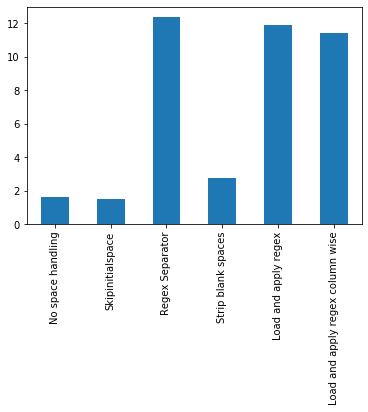

In [47]:
stats_perf_df["avg"].plot(kind="bar")

In [48]:
pd.concat(statistics)

,Address_lenght,Address_type,Name_lenght,Name_type,Salary_lenght,Salary_type
No space handling,45711572.0,object,15272074.0,object,4.998316e+11,int64
Skipinitialspace,45711572.0,object,14272074.0,object,4.998316e+11,int64
Regex Separator,9742850.0,object,12481774.0,object,4.465201e+11,float64
Strip blank spaces,43711572.0,object,13272074.0,object,4.998316e+11,int64
Load and apply regex,43711572.0,object,13272074.0,object,4.998316e+11,int64
Load and apply regex column wise,43711572.0,object,13272074.0,object,4.998316e+11,int64


## Detail of the timing function
If you strugle to read the iteration over all the function, here's example how the it works on the skipinitialspace example

In [57]:
processing_times = []
for i in range(7):
    start = time.time()
    df = pd.read_csv("test_data.csv")
    processing_times.append(time.time() - start)

In [58]:
s = pd.Series(processing_times)
s.name = "Skipinitialspace"
s

0    1.256785
1    1.294549
2    1.319469
3    1.644080
4    1.613763
5    1.623683
6    1.760450
Name: Skipinitialspace, dtype: float64

### Single Run
If you want to try just single processing of the file

In [51]:
def read_csv_regex(data):
    df = pd.read_csv(data, quotechar='"')
    df = df.replace({"^\s*|\s*$":""}, regex=True) # remove front white spaces
    df = df.replace({"":np.nan}) # if there remained only empty string "", change to Nan
    return df

In [52]:
start = time.time()
df = read_csv_regex("test_data.csv")
print(time.time() - start)

11.43640422821045


# Conclusion
We have seens that removing the extra white spaces is a costly operation, which takes at least 50% more time than loading clean .csv. We should always try to persuade our supplier to provide CSV files without extra white spaces. If it's not possible, the fastest approach is to load the data into a dataframe, iterate over the string columns and use `str.strip()`. If the blank spaces are only at the beginning (behind the delimiteres) and on before the delimiters, use pandas's `skipinitialspace=True` which removes these blank spaces during data upload. 